<a href="https://colab.research.google.com/github/alejandro-cermeno/2021_Market_Timing-Cermeno/blob/main/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### El modelo ARIMA de Box and Jenkins (1970)

Alejandro Cermeño 

06/2021

In [30]:
# Configuración premiliminar

    # Librerias necesarias
import os
import pandas as pd
import numpy as np
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from google.colab import drive

    # Directorio 
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/TESIS/Code')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Obtencion de datos

df = pd.read_excel('datos.xlsx', sheet_name= 'datos')

ipsa     = df.iloc[:,4:6]
mexbol   = df.iloc[:,0:2]
spblpgpt = df.iloc[:,2:4]

In [16]:
# Preparacion de datos

series = [mexbol, spblpgpt, ipsa]

    # Limpieza 
for i in range(len(series)):
  series[i] = series[i].dropna() # Elimina valores ausentes
  series[i] = series[i].set_index(list(series[i].columns[[0]])) # Establece el indice

    # Transformacion a retornos
def logret(df):

  '''Tranforma la serie de precios al logaritmo del retorno'''

  logret_series = [] # Almacenamiento de resultados

  for i in range(len(series)):

    logret =(100 * (np.log(df[i]) - np.log(df[i].shift(1)))).dropna()
    logret_series.append(logret)

  return logret_series # Salida

logret_series = logret(series)

         count       max        min       std      skew      kurt
mexbol  7094.0  12.15364 -14.313884  1.404593  0.029926  7.515624
           count        max       min       std      skew       kurt
spblpgpt  4842.0  12.815562 -13.29076  1.372947 -0.597023  12.236378
       count        max        min       std      skew       kurt
ipsa  7686.0  11.803367 -15.215545  1.171008 -0.316004  12.175782




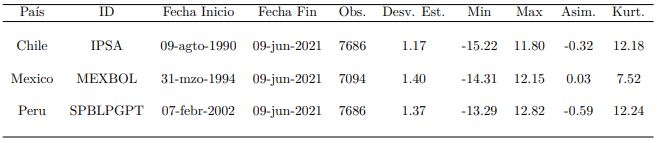

In [26]:
# Inspeccion de datos

    # Estadísticos descriptivos
def describe(df):

  '''Calcula el número de observaciones, desviación estandar, valor mínimo y
  máximo, simetría y kurtosis de las series ingresadas'''

  descrip = [] # Almacenamiento de resultados

  for i in range(len(series)):

    # Se especifican los estadísticos
    descrip = pd.concat([df[i].describe().loc[['count','max', 'min', 'std']].T,
                         df[i].skew().rename('skew'),
                         df[i].kurt().rename('kurt')],
                      axis=1)
    
    descrip.append(descrip) # Consolidación de resultados de series ingresadas

    print(descrip) # Salida

describe(logret_series)
print('')
print('')
Image(filename='estadisticos_descriptivos.JPG') 

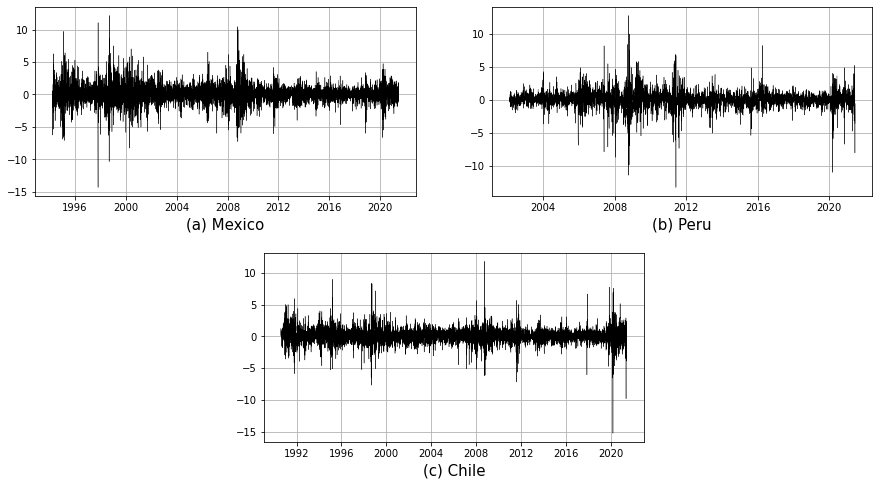

In [41]:
# Grafico de retornos

plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (15,8)

gs = gridspec.GridSpec(2, 4)
gs.update(hspace = 0.3, wspace = 0.5)
ax1 = plt.subplot(gs[0, :2], )
ax1.plot(logret_series[0], color = 'black', linewidth=0.4)
ax1.set_xlabel('(a) Mexico', fontsize=15)

ax2 = plt.subplot(gs[0, 2:])
ax2.plot(logret_series[1], color = 'black', linewidth=0.4)
ax2.set_xlabel('(b) Peru', fontsize=15)

ax3 = plt.subplot(gs[1, 1:3])
ax3.plot(logret_series[2], color = 'black', linewidth=0.4)
ax3.set_xlabel('(c) Chile', fontsize=15)

plt.show()

### Modelo ARIMA

**AR** - AutoRegressive\
**I** - Integrated\
**MA** - Moving *Average*

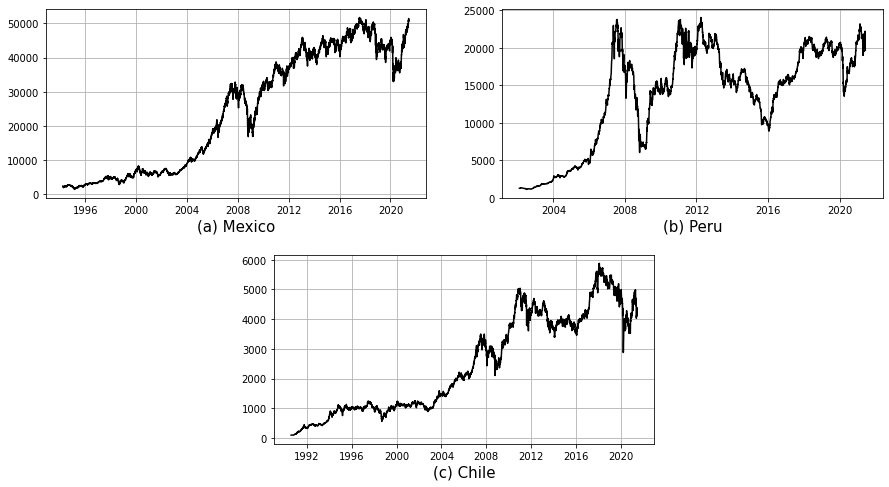

In [72]:
# Grafico de los precios

plt.rcParams['axes.grid'] = True
plt.rcParams["figure.figsize"] = (15,8)

gs = gridspec.GridSpec(2, 4)
gs.update(hspace = 0.3, wspace = 0.5)
ax1 = plt.subplot(gs[0, :2], )
ax1.plot(series[0], color = 'black')
ax1.set_xlabel('(a) Mexico', fontsize=15)

ax2 = plt.subplot(gs[0, 2:])
ax2.plot(series[1], color = 'black')
ax2.set_xlabel('(b) Peru', fontsize=15)

ax3 = plt.subplot(gs[1, 1:3])
ax3.plot(series[2], color = 'black')
ax3.set_xlabel('(c) Chile', fontsize=15)

plt.show()

In [90]:
# Inspeccion de estacionariedad para precios

pais = ['MEXICO', 'PERU', 'CHILE']

      # Prueba ADF 
def prueba_adfuller(df):

  '''Esta función configura el formato del output de la función adfuller()'''

  for i in range(len(series)):
    print('Para', pais[i])
    result=adfuller(df[i])
    labels = ['Prueba ADF','p-value','# rezagos','# Observaci\
    ones']
    for value,label in zip(result,labels):
      print(label+' : '+str(value) )
    if result[1] <= 0.05: # Si p-value menor o igual a 0.5
      print('')
      print("Se rechaza la H_0, la serie es estacionaria")
      print('')
      print('')
    else:
      print('')
      print("Evidencia debil contra la H_0, la serie no es \
      estacionaria")
      print('')
      print('')

prueba_adfuller(series)

Para MEXICO
Prueba ADF : -0.3985310531257595
p-value : 0.9103437501391625
# rezagos : 6
# Observaci    ones : 7088

Evidencia debil contra la H_0, la serie no es       estacionaria


Para PERU
Prueba ADF : -1.9105058022611552
p-value : 0.32713510462965745
# rezagos : 24
# Observaci    ones : 4818

Evidencia debil contra la H_0, la serie no es       estacionaria


Para CHILE
Prueba ADF : -1.081447115367171
p-value : 0.7224135914009558
# rezagos : 29
# Observaci    ones : 7657

Evidencia debil contra la H_0, la serie no es       estacionaria




In [91]:
# Transformacion a primera diferencia

def primera_diferencia(df):

  '''Tranforma las serie a su primera diferencia'''

  dif_series = [] # Almacenamiento de resultados

  for i in range(len(df)):

    dif = (df[i] - df[i].shift(1)).dropna()
    dif_series.append(dif)

  return dif_series # Salida

dif_series = primera_diferencia(series)

In [92]:
# Inspeccion de estacionariedad para precios en primera diferencia

prueba_adfuller(dif_series)

Para MEXICO
Prueba ADF : -37.617033711813654
p-value : 0.0
# rezagos : 5
# Observaci    ones : 7088

Se rechaza la H_0, la serie es estacionaria


Para PERU
Prueba ADF : -13.06027210976731
p-value : 2.054277818463251e-24
# rezagos : 23
# Observaci    ones : 4818

Se rechaza la H_0, la serie es estacionaria


Para CHILE
Prueba ADF : -15.645129427383942
p-value : 1.6220983395551754e-28
# rezagos : 36
# Observaci    ones : 7649

Se rechaza la H_0, la serie es estacionaria




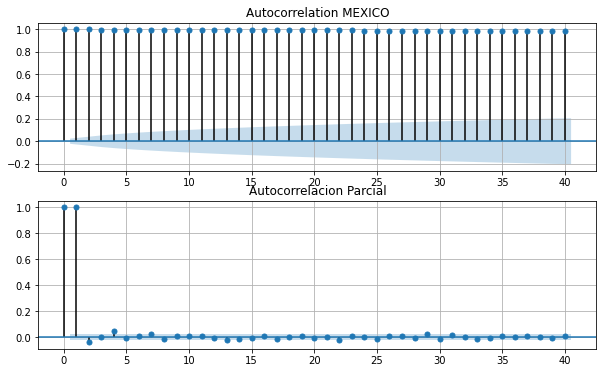

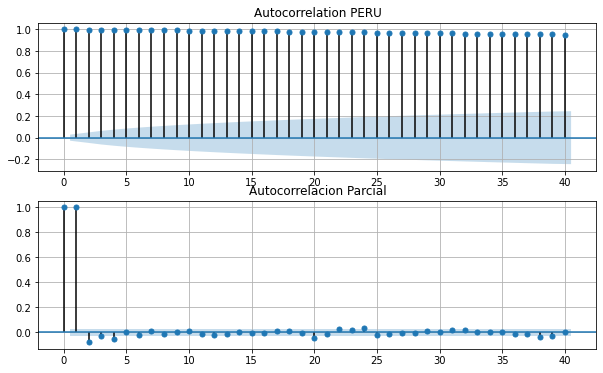

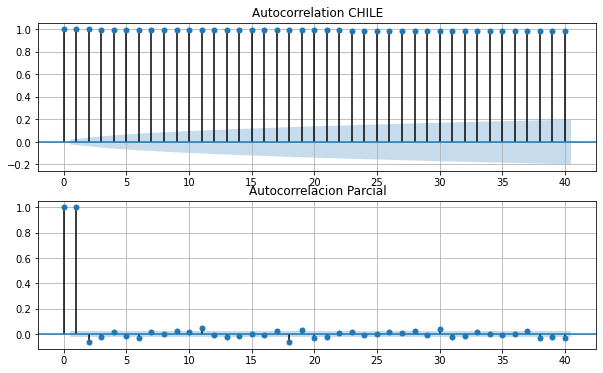

In [115]:
# Gráfico de Autocorrelación y Autocorrelación Parcial

for i in range(len(series)):
  fig = plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(211)
  # Grafico ACF
  fig = sm.graphics.tsa.plot_acf((series[i]),lags=40,ax=ax1, 
                                 title ='Autocorrelation '+pais[i])
  ax2 = fig.add_subplot(212)
  # Grafico PACF
  fig = sm.graphics.tsa.plot_pacf(series[i].dropna(),lags=40,ax=ax2, 
                                  title ='Autocorrelacion Parcial')

In [ ]:
# ...

In [97]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# p: 0 a numero
# d: 0 a numero
# q: 0 a numero



def evaluacion_arima(X, arima_orden):

  '''Esta función un modelo ARIMA(p,d,q)'''

  # División entre datos de entrenamiento y prueba
  X = X.astype('float32')
  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  historial = [x for x in train]

  # Se realizan proyecciones
  proyecciones = list()
  for t in range(len(test)):
  model = ARIMA(historial, order=arima_orden)
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0]
  proyecciones.append(yhat)
  historial.append(test[t])

  # Se calcula el error fuera de la muestra
  rmse = sqrt(mean_squared_error(test, proyecciones))
  return rmse

In [ ]:
def evaluacion_combinaciones(df, orden_p, orden_d, orden_q):
  
  '''Esta función evalua diferentes combinaciones de p, d y q 
  para un modelo ARIMA'''

  df = df.astype('float32')
  mejor_score, mejor_cfg = float("inf"), None
  for p in orden_p:
    for d in orden_d:
      for q in orden_q:
        orden = (p,d,q)
        try:
          rmse = evaluacion_arima(df, orden)
          if rmse < mejor_score:
            mejor_score, mejor_cfg = rmse, orden
          print('ARIMA%s RMSE=%.3f' % (orden,rmse))
        except:
          continue
  print('El mejor ARIMA%s RMSE=%.3f' % (mejor_cfg, mejor_score))